In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv(r"C:\Users\VARSHA\Downloads\creditcard.csv\ccfd\data\creditcard.csv")

# Check for missing values
if data.isnull().sum().sum() > 0:
    data = data.dropna()

# Standardize the 'Amount' column
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])

# Drop columns that are not features
X = data.drop(columns=['Time', 'Class'])
y = data['Class']


In [3]:
# Check the number of features
num_features = data.shape[1] - 2  # excluding 'Time' and 'Class' columns

# Reshape data for Conv1D
X_reshaped = X.values.reshape(X.shape[0], X.shape[1], 1)

input_shape = (num_features, 1)

# Confirm shapes
print(f"Input shape for autoencoder: {input_shape}")
print(f"Shape of X_reshaped: {X_reshaped.shape}")

Input shape for autoencoder: (29, 1)
Shape of X_reshaped: (284807, 29, 1)


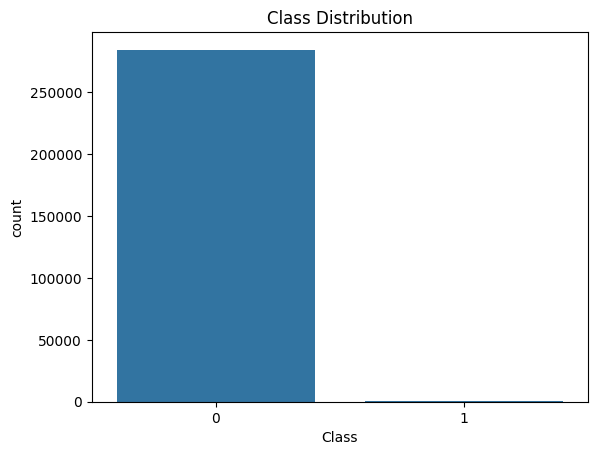

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the classes
sns.countplot(x='Class', data=data)
plt.title('Class Distribution')
plt.show()

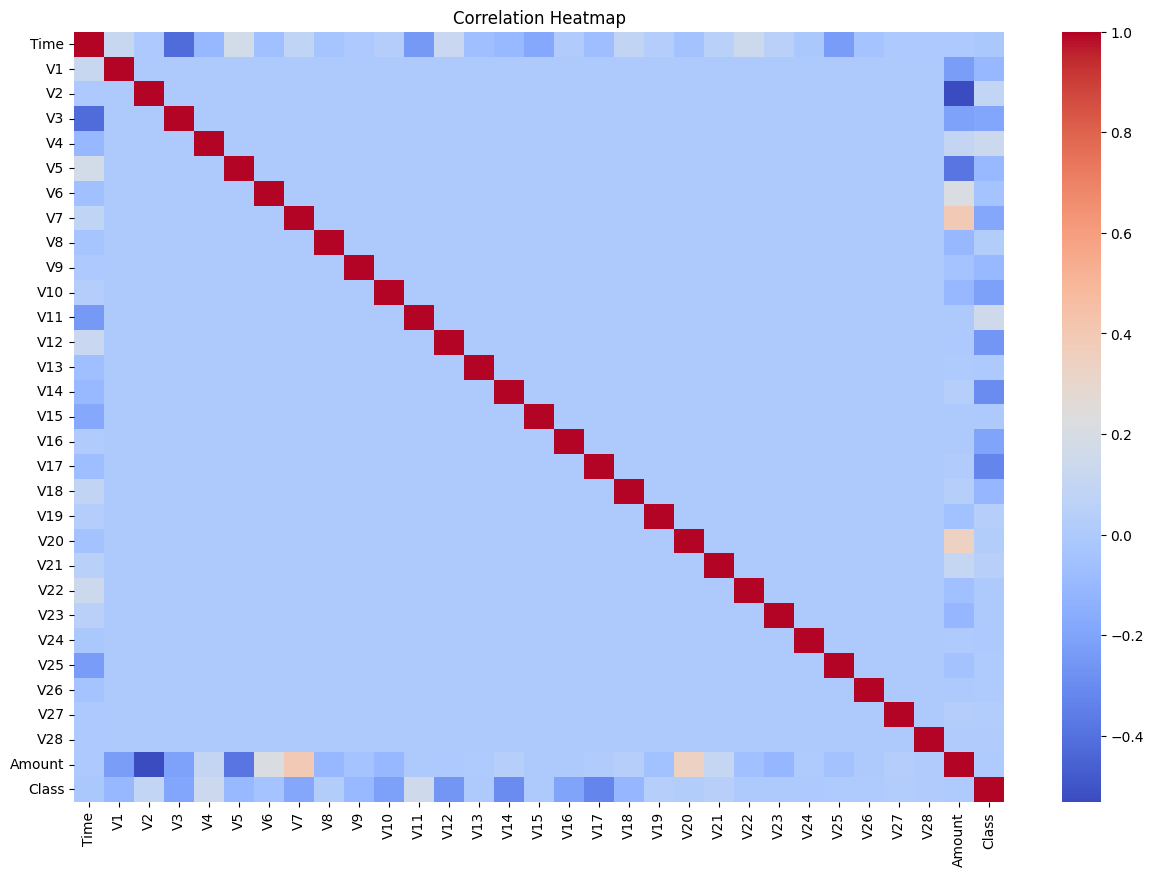

In [5]:
# Correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class SliceLayer(Layer):
    def call(self, inputs):
        return inputs[:, :29, :]


c:\Python311\Lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (None)/charset_normalizer (3.2.0) doesn't match a supported version!
  warnings.warn(


In [7]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization, Dropout

input_shape = (29, 1)  # Confirmed input shape

input_layer = Input(shape=input_shape)

# Encoder
encoder = Conv1D(32, 2, activation='relu', padding='same')(input_layer)
encoder = BatchNormalization()(encoder)
encoder = MaxPooling1D(2, padding='same')(encoder)  # Reduces by half: (29 -> 15)
encoder = Conv1D(16, 2, activation='relu', padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = MaxPooling1D(2, padding='same')(encoder)  # Reduces by half: (15 -> 8)
encoder = Conv1D(8, 2, activation='relu', padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder_output_shape = encoder.shape

# Flatten and bottleneck
flatten = Flatten()(encoder)
encoded = Dense(16, activation='relu')(flatten)  # Bottleneck layer
encoded = Dropout(0.2)(encoded)

# Decoder
decoder = Dense(np.prod(encoder_output_shape[1:]), activation='relu')(encoded)
decoder = Reshape((encoder_output_shape[1], encoder_output_shape[2]))(decoder)
decoder = Conv1D(8, 2, activation='relu', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling1D(2)(decoder)  # Upsampling: (8 -> 16)
decoder = Conv1D(16, 2, activation='relu', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling1D(2)(decoder)  # Upsampling: (16 -> 32)
decoder = Conv1D(32, 2, activation='relu', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = Conv1D(1, 2, activation='sigmoid', padding='same')(decoder)

# Use custom slicing layer
decoder = SliceLayer()(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 29, 32)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 29, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 8)           │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 8, 8)           │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 16, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 16, 16)         │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 32, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 32, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32)         │           128 │
│ (BatchNormalization)            │                        │             

 Total params: 5,505 (21.50 KB)

 Trainable params: 5,281 (20.63 KB)

 Non-trainable params: 224 (896.00 B)

In [8]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Train on non-fraudulent data only
X_train_non_fraud = X_train[y_train == 0]

history = autoencoder.fit(X_train_non_fraud, X_train_non_fraud,
                          epochs=10,
                          batch_size=64,
                          validation_data=(X_test, X_test),
                          shuffle=True)


Epoch 1/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 0.9854 - val_loss: 0.8497
Epoch 2/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 0.8472 - val_loss: 0.8242
Epoch 3/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - loss: 0.8178 - val_loss: 0.8142
Epoch 4/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - loss: 0.8255 - val_loss: 0.8091
Epoch 5/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - loss: 0.8066 - val_loss: 0.8035
Epoch 6/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 53s 15ms/step - loss: 0.8060 - val_loss: 0.8014
Epoch 7/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - loss: 0.8148 - val_loss: 0.8002
Epoch 8/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 102s 20ms/step - loss: 0.8038 - val_loss: 0.8018
Epoch 9/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 56s 16ms/step - loss: 0.8020 - val_loss: 0.7950
Epoch 10/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 61s 17ms/step - loss: 0.7976 - val_loss: 0.7952


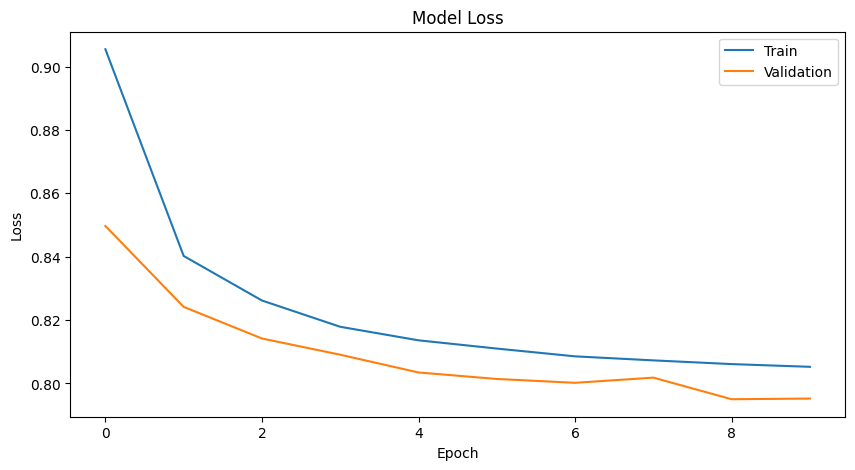

In [9]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [10]:
# Predict the reconstruction
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

7121/7121 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


In [11]:
# Compute reconstruction error
train_mse = np.mean(np.power(X_train.reshape(X_train.shape[0], X_train.shape[1]) - 
                             X_train_pred.reshape(X_train_pred.shape[0], X_train_pred.shape[1]), 2), axis=1)
test_mse = np.mean(np.power(X_test.reshape(X_test.shape[0], X_test.shape[1]) - 
                            X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[1]), 2), axis=1)

In [12]:
# Define a threshold for anomaly detection
threshold = np.percentile(train_mse, 95)

In [13]:
# Identify anomalies
y_train_pred = (train_mse > threshold).astype(int)
y_test_pred = (test_mse > threshold).astype(int)

In [14]:
# Evaluate the model
from sklearn.metrics import classification_report
print("Classification Report for Training Data")
print(classification_report(y_train, y_train_pred))

print("Classification Report for Test Data")
print(classification_report(y_test, y_test_pred))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    227451
           1       0.03      0.85      0.06       394

    accuracy                           0.95    227845
   macro avg       0.51      0.90      0.52    227845
weighted avg       1.00      0.95      0.97    227845

Classification Report for Test Data
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.86      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.52     56962
weighted avg       1.00      0.95      0.97     56962



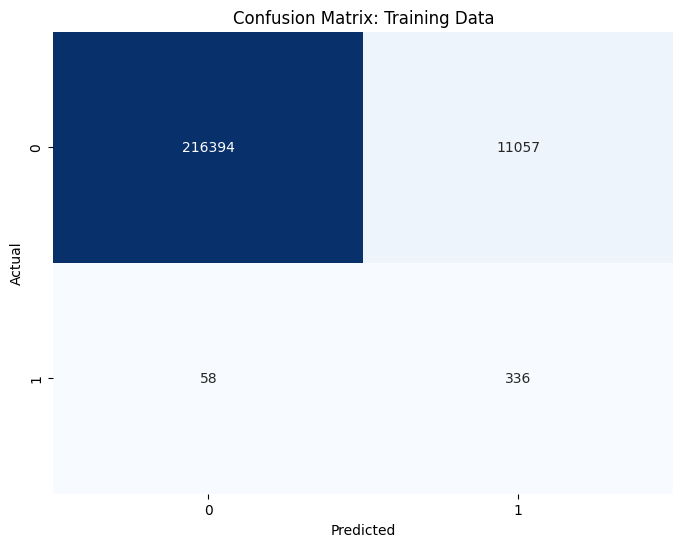

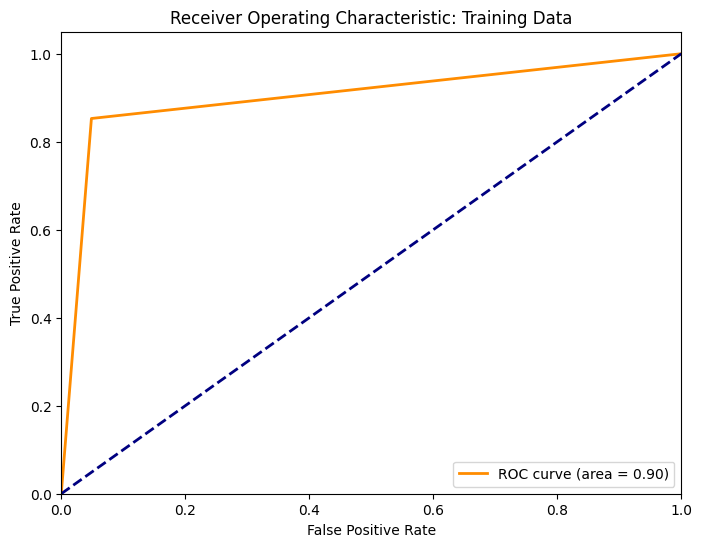

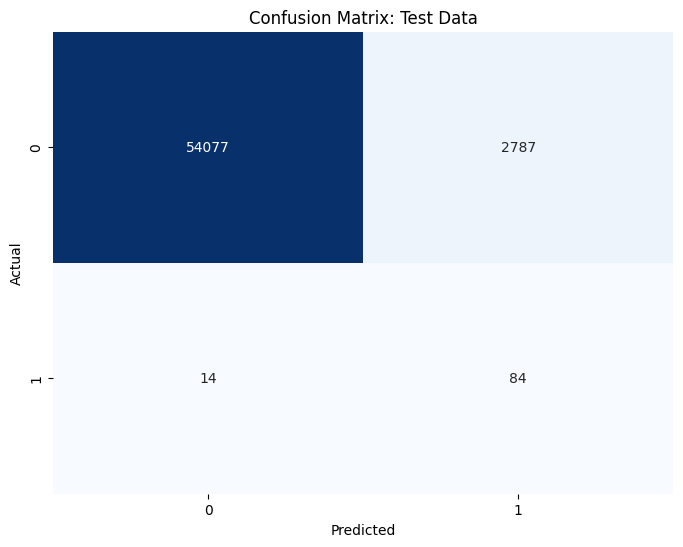

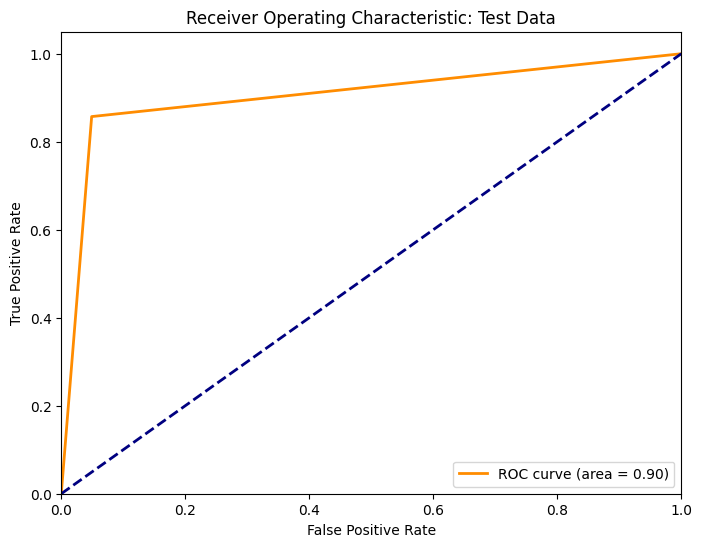

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {title}')
    plt.legend(loc="lower right")
    plt.show()

# Assuming y_train, y_train_pred, y_test, y_test_pred are defined

# Plot for Training Data
plot_confusion_matrix(y_train, y_train_pred, 'Training Data')
plot_roc_curve(y_train, y_train_pred, 'Training Data')

# Plot for Test Data
plot_confusion_matrix(y_test, y_test_pred, 'Test Data')
plot_roc_curve(y_test, y_test_pred, 'Test Data')


In [21]:
# Save the autoencoder model
autoencoder.save('model/autoencoder_model.keras')

In [22]:
# Save the scaler
import joblib
joblib.dump(scaler, 'model/scaler.joblib')

['model/scaler.joblib']

In [23]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Register the custom layer when loading the model
autoencoder = load_model('model/autoencoder_model.keras', custom_objects={'SliceLayer': SliceLayer})


c:\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
